In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import scipy
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import model_selection

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,fbeta_score,roc_auc_score,classification_report,make_scorer,balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer
from imblearn.under_sampling import RandomUnderSampler

import random
import tensorflow 
import tensorflow as tf

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    f1 = f1_score(y_test,pred)
    f2 = fbeta_score(y_test,pred,beta=2)
    balanced_acc = balanced_accuracy_score(y_test,pred)
    print('Confusion Matrix')
    print(confusion)
    print('\n')
    print('정확도:',accuracy.round(3),'정밀도:', precision.round(3),'재현율:',recall.round(3),'AUC:',roc_auc.round(3),'F1:',f1.round(3),'F2:',f2.round(3),'Balanced_Accuracy:',balanced_acc.round(3))

def build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio):
    
    random.seed(1234)
    np.random.seed(1234)
    tf.random.set_seed(1234)
    
    input_layer = Input(shape = (X.shape[1],))
    
    encoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(input_layer)
    encoded = Dropout(dropout_ratio)(encoded)
    encoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    
    encoded = Dense(latent_vector, activation = function)(encoded) 
    
    decoded = Dense(inner, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(encoded)
    decoded = Dropout(dropout_ratio)(decoded)
    decoded = Dense(outer, activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)
    
    output_layer = Dense(X.shape[1], activation = function,kernel_initializer='random_uniform',bias_initializer='zeros')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

def train_autoencoder(model,X,batch,epoch,val,patience):
    history = model.fit(X, X,
                              batch_size = batch, epochs = epoch, 
                              validation_split = val,callbacks=EarlyStopping(patience=patience))
    
    print('\n')
    sns.set(font_scale=1.0)
    plt.figure(figsize=(6,4))
    plt.grid(True)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.xlabel('Epoch'); plt.ylabel('loss')
    plt.show()

    return history 

def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss, bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

def reconstruction_loss(model,x_train,x_test):
    
    x_train_pred  = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    print('\n')
    plt.figure(figsize=(6,4))
    plt.title('Reconstruction MAE Loss')
    plt.hist(train_mae_loss,color='blue',density=True,label='Train')
    plt.hist(test_mae_loss,bins=40,color='red',density=True,label='Test')
    plt.legend()
    plt.show()

    threshold_train = np.max(train_mae_loss) 
    threshold_test = np.max(test_mae_loss) 
    print('\n')
    print("Train (Normal Only) Reconstruction error threshold:", threshold_train)
    print('\n')
    print("Test Reconstruction error threshold:", threshold_test)
    
    return train_mae_loss, test_mae_loss, threshold_train, threshold_test

def anomaly_threshold(threshold,model):
    
    test_score_df = pd.DataFrame(x_test[:])
    test_score_df['loss'] = test_mae_loss 
    test_score_df['threshold'] = threshold 
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['score'] = test_score_df["anomaly"].astype(int) # 예측 레이블 
    get_clf_eval(y_test,test_score_df['score'],test_score_df['loss'])
    print('\n')
    print(classification_report(y_test, test_score_df['score'],target_names=['양품','불량']))
    
    test_error = pd.DataFrame({'Reconstruction_error': test_mae_loss,'True_class': y_test.reset_index()['Score']})

    plt.figure(figsize=(8, 6))
    plt.title('AutoEncoder Reconstruction Error', fontsize=12)
    plt.scatter(test_error.index[test_error['True_class'] == 0],test_error[test_error['True_class'] == 0]['Reconstruction_error'], s = 10, label = 'Normal',color='blue',marker='+')
    plt.scatter(test_error.index[test_error['True_class'] == 1],test_error[test_error['True_class'] == 1]['Reconstruction_error'], s = 10, label = 'Fault',color='red',marker='+')
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=10)
    plt.axhline(threshold,color = 'red', ls = '--', label = 'Threshold = %0.2f' % (threshold))
    plt.legend(bbox_to_anchor=(1.0, 1.03))
    plt.show()
    

def pred_anomaly_threshold(threshold):
    
    pred_score_df = pd.DataFrame(test_inputs[:])
    pred_score_df['mae_loss'] = pred_mae_loss 
    pred_score_df['threshold'] = threshold 
    pred_score_df['anomaly'] = pred_score_df['mae_loss'] > pred_score_df['threshold']
    pred_score_df['score'] = pred_score_df["anomaly"].astype(int) # 예측 레이블 
    print(pred_score_df['score'].value_counts())
    
    pred_check = pd.concat([test_inputs.reset_index(drop=True),pred_score_df['mae_loss'],pred_score_df['threshold'],pred_score_df['anomaly'],pred_score_df['score']],axis=1)
    pred_error = pd.DataFrame({'Reconstruction_error': pred_score_df['mae_loss'],'Anomaly': pred_score_df['score']})

    pred_df = pd.concat([test_inputs,pred_check.set_index(test_inputs.index)[['mae_loss','threshold','anomaly','score']]],axis=1)
    pred_normal = pred_df[pred_df['score'] ==0]
    pred_fault = pred_df[pred_df['score'] ==1]
    
    groups = pred_error.groupby('Anomaly')
    fig, ax = plt.subplots(figsize = (20,8))

    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='+', ms=10, linestyle='',label= "Normal" if name == 0 else "Anomaly",color='blue' if name == 0 else "red")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="orange", zorder=150, label='Fault Threshold')
    ax.legend()
    plt.title('AutoEncoder Anomaly Detection',fontsize=20)
    plt.ylabel("Test Reconstruction error")
    plt.xlabel("Data Index")
    plt.grid()
    plt.show();
    
    return pred_df,pred_normal,pred_fault

In [3]:
def make_lists(_id,cols):
    
    #### Fault Prediction ID & 특정 변수 선택
    df_oneline = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[imp_cols[cols]]).columns[0]
    
    #### 현재 불량 예측 ID변수 값
    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]
    
    #### 정상(학습) 데이터 중앙값
    median_val = Trained_Normal[imp_cols[cols]].median()
    
    return df_oneline,col,col_value,median_val  


def imp_diagnosis(_id,cols,lower_quantile,col_range):
    
    #### Fault Prediction 해당 _ID & 정보 출력 
    df_oneline = pred_fault[pred_fault['_id'] == fault_ids[_id]]
    col = pd.DataFrame(pred_fault[imp_cols[cols]]).columns[0]

    #### 현재 불량 예측 ID변수 값
    df_oneline_col = df_oneline[col]
    col_value = df_oneline_col.values[0]

    print(col,' = ',col_value)
    print('\n')

    ### 정상(학습) 데이터 해당 변수 통계량 비교 
    print('하위 측정값 설정:',Trained_Normal[imp_cols[cols]].quantile(lower_quantile))
    print('중앙 측정값 :',Trained_Normal[imp_cols[cols]].median())
    print('상위 10% 측정값 :',Trained_Normal[imp_cols[cols]].quantile(0.9))

    print('\n')
    print('진단 결과')

    if (col_value >= Trained_Normal[imp_cols[cols]].quantile(lower_quantile)) & (col_value <= Trained_Normal[imp_cols[cols]].quantile(0.9)):

        print('Value in Set Normal Quantile Range')
        print(col, ' --> 현재 값 유지')
        print('\n')
        print('==========================================================================================')
        print('\n')

    else:

        if (col_value > Trained_Normal[imp_cols[cols]].quantile(0.9)):

                print(col,'하향 조정 대상-->  -',col_value - Trained_Normal[imp_cols[cols]].quantile(0.9))
                print('\n')

                if col_value - Trained_Normal[imp_cols[cols]].quantile(0.9) >= col_range:

                    df_oneline[imp_cols[cols]] = df_oneline[imp_cols[cols]].iloc[0] - (col_value - Trained_Normal[imp_cols[cols]].quantile(0.9))
                    print('추천 의사결정 --> ',col, '조정')
                else:
                    print('추천 의사결정 --> ',col, '유지')

        elif (col_value < Trained_Normal[imp_cols[cols]].quantile(lower_quantile)):

            print(col,'상향 조정 대상-->  +',Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value)
            print('\n')

            if Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value >= col_range:

                df_oneline[imp_cols[cols]] = df_oneline[imp_cols[cols]].iloc[0] + Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value
                print('추천 의사결정 --> ',col, '조정')
            else:
                print('추천 의사결정 --> ',col, '유지')


        elif (col_value > Trained_Normal[imp_cols[cols]].quantile(lower_quantile)):

            print(col,'하향 조정 대상--> ',Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value)
            print('\n')

            if np.abs(Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value) >= col_range:

                df_oneline[imp_cols[cols]] = df_oneline[imp_cols[cols]].iloc[0] + Trained_Normal[imp_cols[cols]].quantile(lower_quantile) - col_value
                print('추천 의사결정 --> ',col, '조정')

            else:
                print('추천 의사결정 --> ',col, '유지')

        print('\n')
        print('==========================================================================================')
        print('\n')
        
    df_col = df_oneline[imp_cols[cols]]
    
    return df_col


def comprehensive_fault_diagnosis(_id,lower_quantile,col_range):
    
    col_name = []
    list_col_value = []
    list_median_value = []

    for cols in range(0,len(imp_cols)):
        df_oneline,col,col_value,median_val = make_lists(_id,cols)

        col_name.append(col)
        list_col_value.append(col_value)
        list_median_value.append(median_val)
        
    print('Id --> ',df_oneline['_id'].iloc[0])
    print('\n')
    print('Columns:',col_name)
    print('\n')
    print('Column Values:',list_col_value)
    print('\n')
    print('Median Normal Values:',list_median_value)
    print('\n')
    print('Confidence Range = ','| Input - Upper/Lower Boundary | ±',col_range)
    print('===========================================================================================')
    
    #### 진단 결과
    
    print('Diagnosis Result -->')
    print('\n')

    dfs = []
    for cols in range(0,len(imp_cols)):

        df_col = imp_diagnosis(_id,cols,lower_quantile,col_range)
        dfs.append(df_col)

    df_cols = pd.DataFrame(np.array(dfs).reshape(-1,1)).T
    df_cols.columns = imp_cols
    input_adjusted = df_cols

    #### 폴리곤 차트
    df = pd.DataFrame({'Columns': col_name, 'Top_Features': list_col_value, 'Median_Normal': list_median_value})
    df = df.T.rename(columns=df.T.iloc[0]).iloc[1:].reset_index().rename(columns={'index':'Type'})
    
    labels = df.columns[1:]
    num_labels = len(labels)    

    angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] 
    angles += angles[:1]   

    my_palette = plt.cm.get_cmap("winter", len(df.index)) 
    sns.set(font_scale=1.0)
    fig = plt.figure(figsize=(18,18))
    #plt.grid(True)
    fig.set_facecolor('white')
    ax = fig.add_subplot(polar=True)

    for i, row in df.iterrows():    
        color = my_palette(i)    
        data = df.iloc[i].drop('Type').tolist()    
        data += data[:1]        

        ax.set_theta_offset(pi / 2) 
        ax.set_theta_direction(-1) 

        plt.xticks(angles[:-1], labels, fontsize=25) 
        ax.tick_params(axis='x', which='major', pad=65) 
        ax.set_rlabel_position(0) 

        plt.suptitle('ID = ' + fault_ids[_id],fontsize=30)
        #plt.title('ID = ' + fault_ids[_id],fontsize=30)
        plt.ylim(0,df.T.iloc[1:].max().sort_values(ascending=False)[0])

        ax.plot(angles, data, color=color, linewidth=2, linestyle='solid', label=row.Type)
        ax.fill(angles, data, color=color, alpha=0.45)


    for g in ax.yaxis.get_gridlines():
        g.get_path()._interpolation_steps = len(labels) 

    spine = Spine(axes=ax,spine_type='circle',path=Path.unit_regular_polygon(len(labels)))
    spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)           
    ax.spines = {'polar':spine} 

    plt.legend(loc=(1.0,1.0))
    plt.show()
    
    return input_adjusted

def optimization(_id):
    
    #### 조정값 재예측 
    input_adjusted_scaled = pd.DataFrame(scaler.transform(input_adjusted),columns = input_adjusted.columns)
    input_adjusted_pred = autoencoder.predict(input_adjusted_scaled)
    input_adjusted_mae_loss = np.mean(np.abs(input_adjusted_pred - input_adjusted_scaled), axis=1)
    mae_loss  = input_adjusted_mae_loss.iloc[0]

    print('Optimization Result')
    print('\n')
    print('Threshold = ',threshold )
    print('Original MAE Loss = ',pred_fault[pred_fault['_id'] == fault_ids[_id]]['mae_loss'].iloc[0])
    print('Adjusted MAE Loss = ',mae_loss)
    print('\n')
    if mae_loss < threshold:
        print('Predicted --> Normal')
    else:
        print('Predicted --> Fault')
        print('Continue Optimization')

#### 획일값 갖는 변수 제거 

In [4]:
train = pd.read_csv('Train_Valid.csv')
train.shape

(28596, 50)

In [5]:
#### 획일값 갖는 변수 제거 

Input_Data = train.drop(['M_CURRENT_PROGRAM_NUMBER','M_sequence_number','M_CURRENT_FEEDRATE','Machining_Process','index','Score'],axis=1)
input_filtered = Input_Data.loc[:,Input_Data.apply(pd.Series.nunique) != 1]

#### 학습/검증 데이터 분할 [stratify = y 적용 [ 불균형 비율 약 3.65% 감안]]

In [6]:
X = train[input_filtered.columns]
y = train['Score']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=2021)

ros_test = RandomUnderSampler(sampling_strategy=0.8,random_state=2021)   
X_test,y_test = ros_test.fit_resample(X_test,y_test)   

print(X_train.shape, X_test.shape)
print('\n')
print(y_train.value_counts())
print('\n')
print(y_test.value_counts())

(21447, 40) (3471, 40)


Score
0    16819
1     4628
Name: count, dtype: int64


Score
0    1928
1    1543
Name: count, dtype: int64


#### 집단간 비교 시 P-value 5% 기준 변수 선택 [ 학습 데이터 기준]

In [7]:
Train = pd.concat([X_train,y_train],axis=1)
Pass = Train[Train['Score']==0].drop(['Score'],axis=1)
Fail = Train[Train['Score']==1].drop(['Score'],axis=1)

T_Test = stats.ttest_ind(Pass,Fail,equal_var=False) # equal_var=True
Columns = pd.DataFrame(X_train.columns).rename(columns={0:'Columns'})
P_Value = pd.DataFrame(T_Test[1]).rename(columns={0:'P-Value'})
Concat_columns_pvalues = pd.concat([Columns,P_Value],axis=1).dropna()

ttest_vals = Concat_columns_pvalues[Concat_columns_pvalues['P-Value'] < 0.05]['Columns'].to_list()
print('5% Significance Level --> ',len(ttest_vals))

5% Significance Level -->  32


#### 로지스틱 회귀 P-value 5%기준 변수 선택 [ 학습 데이터 기준]

In [8]:
#### 대상 변수 스케일링 진행
scaler = StandardScaler()
scale_cols =  X_train.columns
scaled_X = scaler.fit_transform(X_train[scale_cols])
scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
scaled_X = scaled_X.set_index(X_train.index)

#### 로지스틱 회귀 구축
X = sm.add_constant(scaled_X)
model = sm.Logit(y_train,X)
results = model.fit()

#### 로지스틱 회귀 결과
LR_Coeff = results.summary()
#print(LR_Coeff)
print('\n')

#### 유의변수 출력
lr_vals = results.pvalues[results.pvalues < 0.05].index.tolist()
lr_vals.remove('const')
print('5% Significance Level --> ',len(lr_vals))

Optimization terminated successfully.
         Current function value: 0.270688
         Iterations 8


5% Significance Level -->  16


In [9]:
def feature_selection(method):
    
    if method == "Welch's T-Test":
        
        X_train_new = X_train[ttest_vals]
        X_test_new = X_test[ttest_vals]
    
    if method == 'Logistic Regression':
        
        X_train_new = X_train[lr_vals]
        X_test_new = X_test[lr_vals]
        
    return X_train_new, X_test_new

In [10]:
#### 기준 선택
X_train, X_test = feature_selection(method = "Logistic Regression") # Logistic Regression

#### 정상 데이터 [ 학습] & 검증 데이터 [ Normal & Fault 혼합] 분리 

In [11]:
Train_All = pd.concat([X_train,y_train],axis=1)
X_train_Normal = Train_All[Train_All['Score'] == 0].drop(['Score'],axis=1)

X_train_Normal.shape

(16819, 16)

#### 데이터 스케일링

In [12]:
scaler = MinMaxScaler()

scaler.fit(X_train_Normal)
x_train = pd.DataFrame(scaler.transform(X_train_Normal),columns = X_train_Normal.columns)

scaler.fit(X_test)
x_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

x_train.shape, x_test.shape

((16819, 16), (3471, 16))

#### AutoEncoder 파라미터 설정

In [13]:
X = x_train

outer = 140
inner = 70
latent_vector = 10

dropout_ratio = 0.1
function = 'relu'

batch = 200
epoch = 1000
val = 0.1
patience = 10

#### AutoEncoder 학습 

Epoch 1/1000
76/76 [==============================] - 1s 3ms/step - loss: 0.1096 - val_loss: 0.0349
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0317
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0172
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0076
Epoch 5/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 6/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 7/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 8/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 9/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 10/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0037

76/76 [==============================] - 0s 2ms/step - loss: 9.2503e-04 - val_loss: 7.6999e-04
Epoch 81/1000
76/76 [==============================] - 0s 2ms/step - loss: 9.0729e-04 - val_loss: 7.9155e-04
Epoch 82/1000
76/76 [==============================] - 0s 2ms/step - loss: 9.0777e-04 - val_loss: 7.4972e-04
Epoch 83/1000
76/76 [==============================] - 0s 2ms/step - loss: 9.0460e-04 - val_loss: 7.5478e-04
Epoch 84/1000
76/76 [==============================] - 0s 2ms/step - loss: 8.9090e-04 - val_loss: 7.4477e-04
Epoch 85/1000
76/76 [==============================] - 0s 2ms/step - loss: 8.8866e-04 - val_loss: 7.6199e-04
Epoch 86/1000
76/76 [==============================] - 0s 2ms/step - loss: 8.6677e-04 - val_loss: 7.1499e-04
Epoch 87/1000
76/76 [==============================] - 0s 2ms/step - loss: 8.6632e-04 - val_loss: 7.1956e-04
Epoch 88/1000
76/76 [==============================] - 0s 2ms/step - loss: 8.7442e-04 - val_loss: 7.2195e-04
Epoch 89/1000
76/76 [============

Epoch 155/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4423e-04 - val_loss: 3.7705e-04
Epoch 156/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4210e-04 - val_loss: 3.9042e-04
Epoch 157/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4483e-04 - val_loss: 3.7266e-04
Epoch 158/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4219e-04 - val_loss: 3.7242e-04
Epoch 159/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4351e-04 - val_loss: 3.8093e-04
Epoch 160/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.3864e-04 - val_loss: 3.7910e-04
Epoch 161/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.2897e-04 - val_loss: 3.7450e-04
Epoch 162/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.2975e-04 - val_loss: 3.7135e-04
Epoch 163/1000
76/76 [==============================] - 0s 2ms/step - loss: 5.4862e-04 - val_loss: 4.3323e-04
Epoch 164/

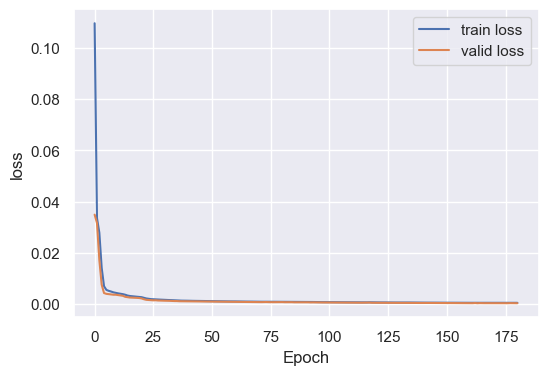

In [14]:
autoencoder = build_autoencoder(X,outer,inner,latent_vector,function,dropout_ratio)

history = train_autoencoder(autoencoder,X,batch,epoch,val,patience)

109/109 [==============================] - 0s 406us/step




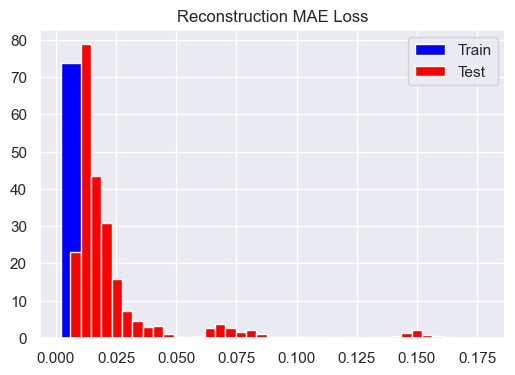



Train (Normal Only) Reconstruction error threshold: 0.12694409808587298


Test Reconstruction error threshold: 0.17790962250424414


In [15]:
train_mae_loss, test_mae_loss, threshold_train, threshold_test = reconstruction_loss(autoencoder,x_train,x_test)

#plt.title('Log Reconstruction Loss')
#plt.hist(np.log(train_mae_loss),color='blue',label='Log Train',bins=40)
#plt.hist(np.log(test_mae_loss),color='red',label='Log Test',bins=40)

#### AutoEncoder 성능 검증

In [16]:
#thresholds = np.arange(0.025, 0.031, 0.001).tolist()
#print(thresholds)

In [17]:
#for i in range(len(thresholds)):
#    print('Threshold --> ',thresholds[i])
#    anomaly_threshold(threshold = thresholds[i], model = autoencoder) 

Confusion Matrix
[[1651  277]
 [ 216 1327]]


정확도: 0.858 정밀도: 0.827 재현율: 0.86 AUC: 0.917 F1: 0.843 F2: 0.853 Balanced_Accuracy: 0.858


              precision    recall  f1-score   support

          양품       0.88      0.86      0.87      1928
          불량       0.83      0.86      0.84      1543

    accuracy                           0.86      3471
   macro avg       0.86      0.86      0.86      3471
weighted avg       0.86      0.86      0.86      3471



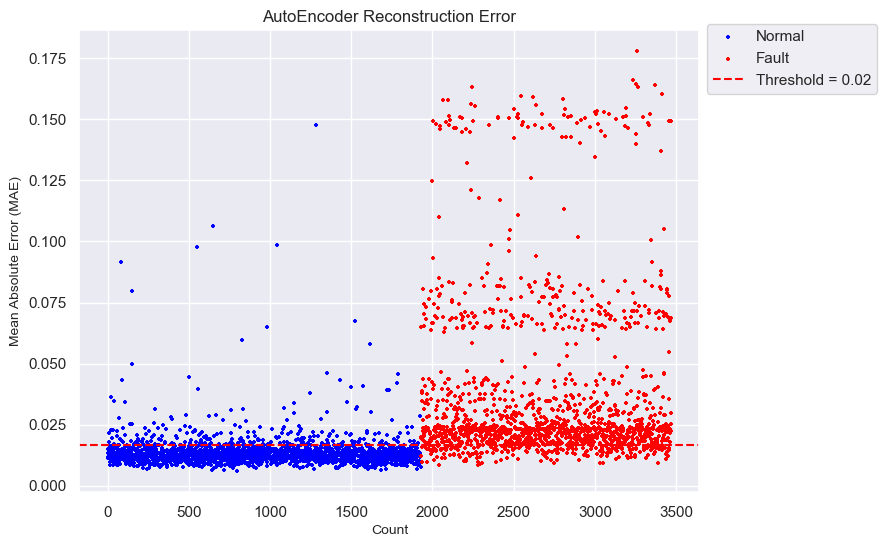

In [18]:
anomaly_threshold(threshold = 0.0165, model = autoencoder) 

#### Test Data [Unlabeled] 예측 & 정보 정리

98/98 [==============================] - 0s 386us/step


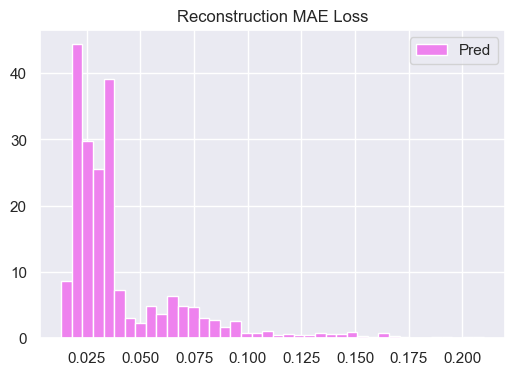

score
0    2988
1     129
Name: count, dtype: int64


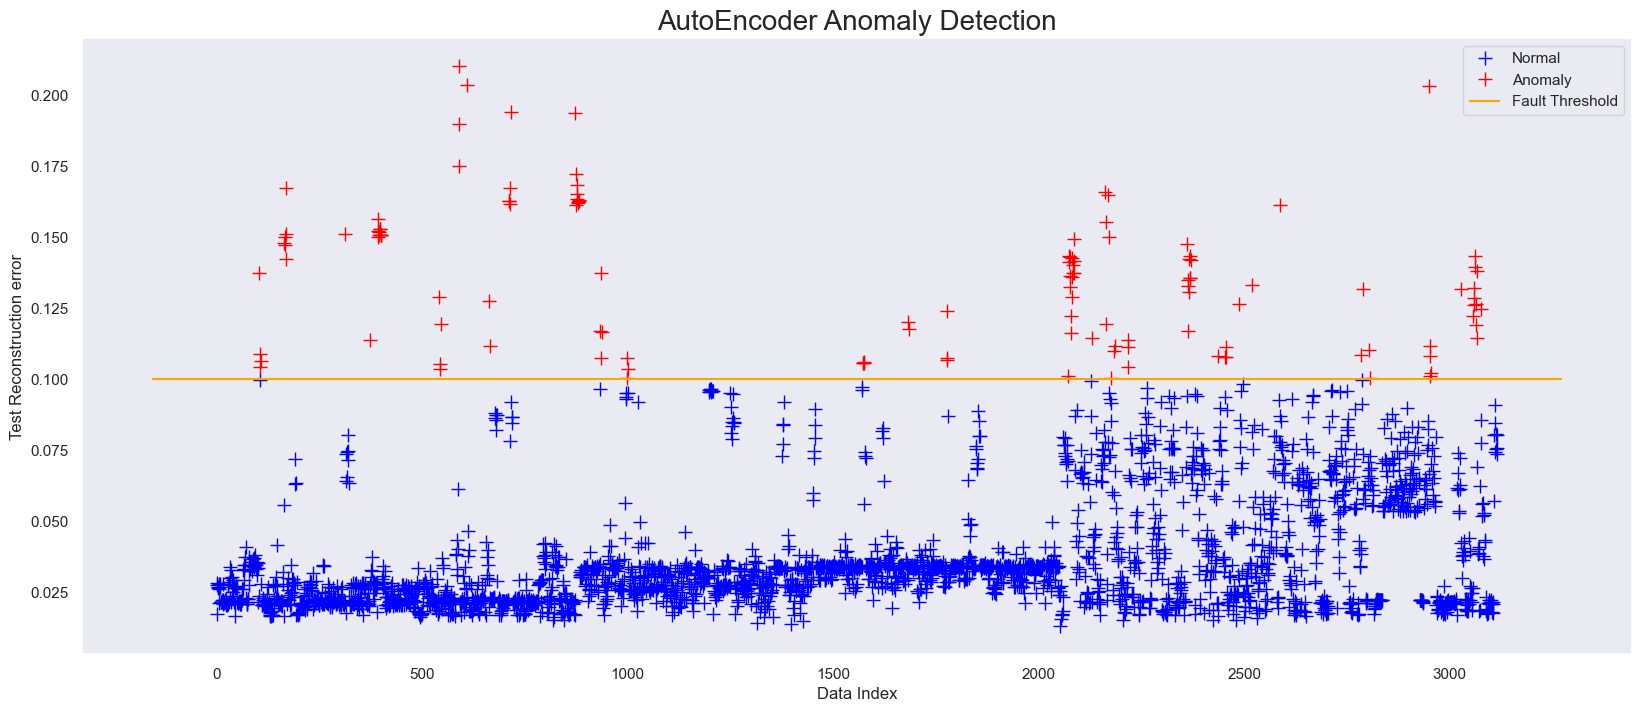

In [19]:
#### Test 데이터 업로드 & 변수 선택 적용
test = pd.read_csv('Test.csv')
test_inputs = test[lr_vals] # ttest_vals

#### Test 데이터 스케일링
scaler.fit(test_inputs)
test_scaled = pd.DataFrame(scaler.transform(test_inputs),columns = test_inputs.columns)

#### AutoEncoder 예측
pred = autoencoder.predict(test_scaled)
pred_mae_loss = np.mean(np.abs(test_scaled - pred), axis=1)

#### 재구성 손실 그래프
plt.figure(figsize=(6,4))
plt.title('Reconstruction MAE Loss')
plt.hist(pred_mae_loss,bins=40,color='violet',density=True,label='Pred')
plt.legend()
plt.show()

#### 재구성 손실 기반 임계값 설정
threshold = 0.1

#### 임계값 기반 정상/불량 예측 개수 최종 확인
pred_df,pred_normal,pred_fault = pred_anomaly_threshold(threshold)

#### 불량예측 데이터 개별 ID 부여 
pred_fault = pred_fault.reset_index(drop=True)

dfs = []

for i in range(0,len(pred_fault)):
    ids = 'ID_20231108_'+str(i)
    dfs.append(ids)

pred_fault['_id'] = pd.DataFrame(np.array(dfs))

#### 정보 정리 [ 입력변수 / 학습(정상)데이터/ 불량예측 ID List 명칭]
imp_cols = lr_vals # ttest_vals
Trained_Normal = X_train_Normal
fault_ids = pred_fault['_id'].tolist()

#### 공정 최적화

- #### Test Data 중 불량 예측값 대상으로 진행 

In [20]:
_id = 0 # 최적화 대상 ID 인덱스 

ID -->  ID_20231108_0


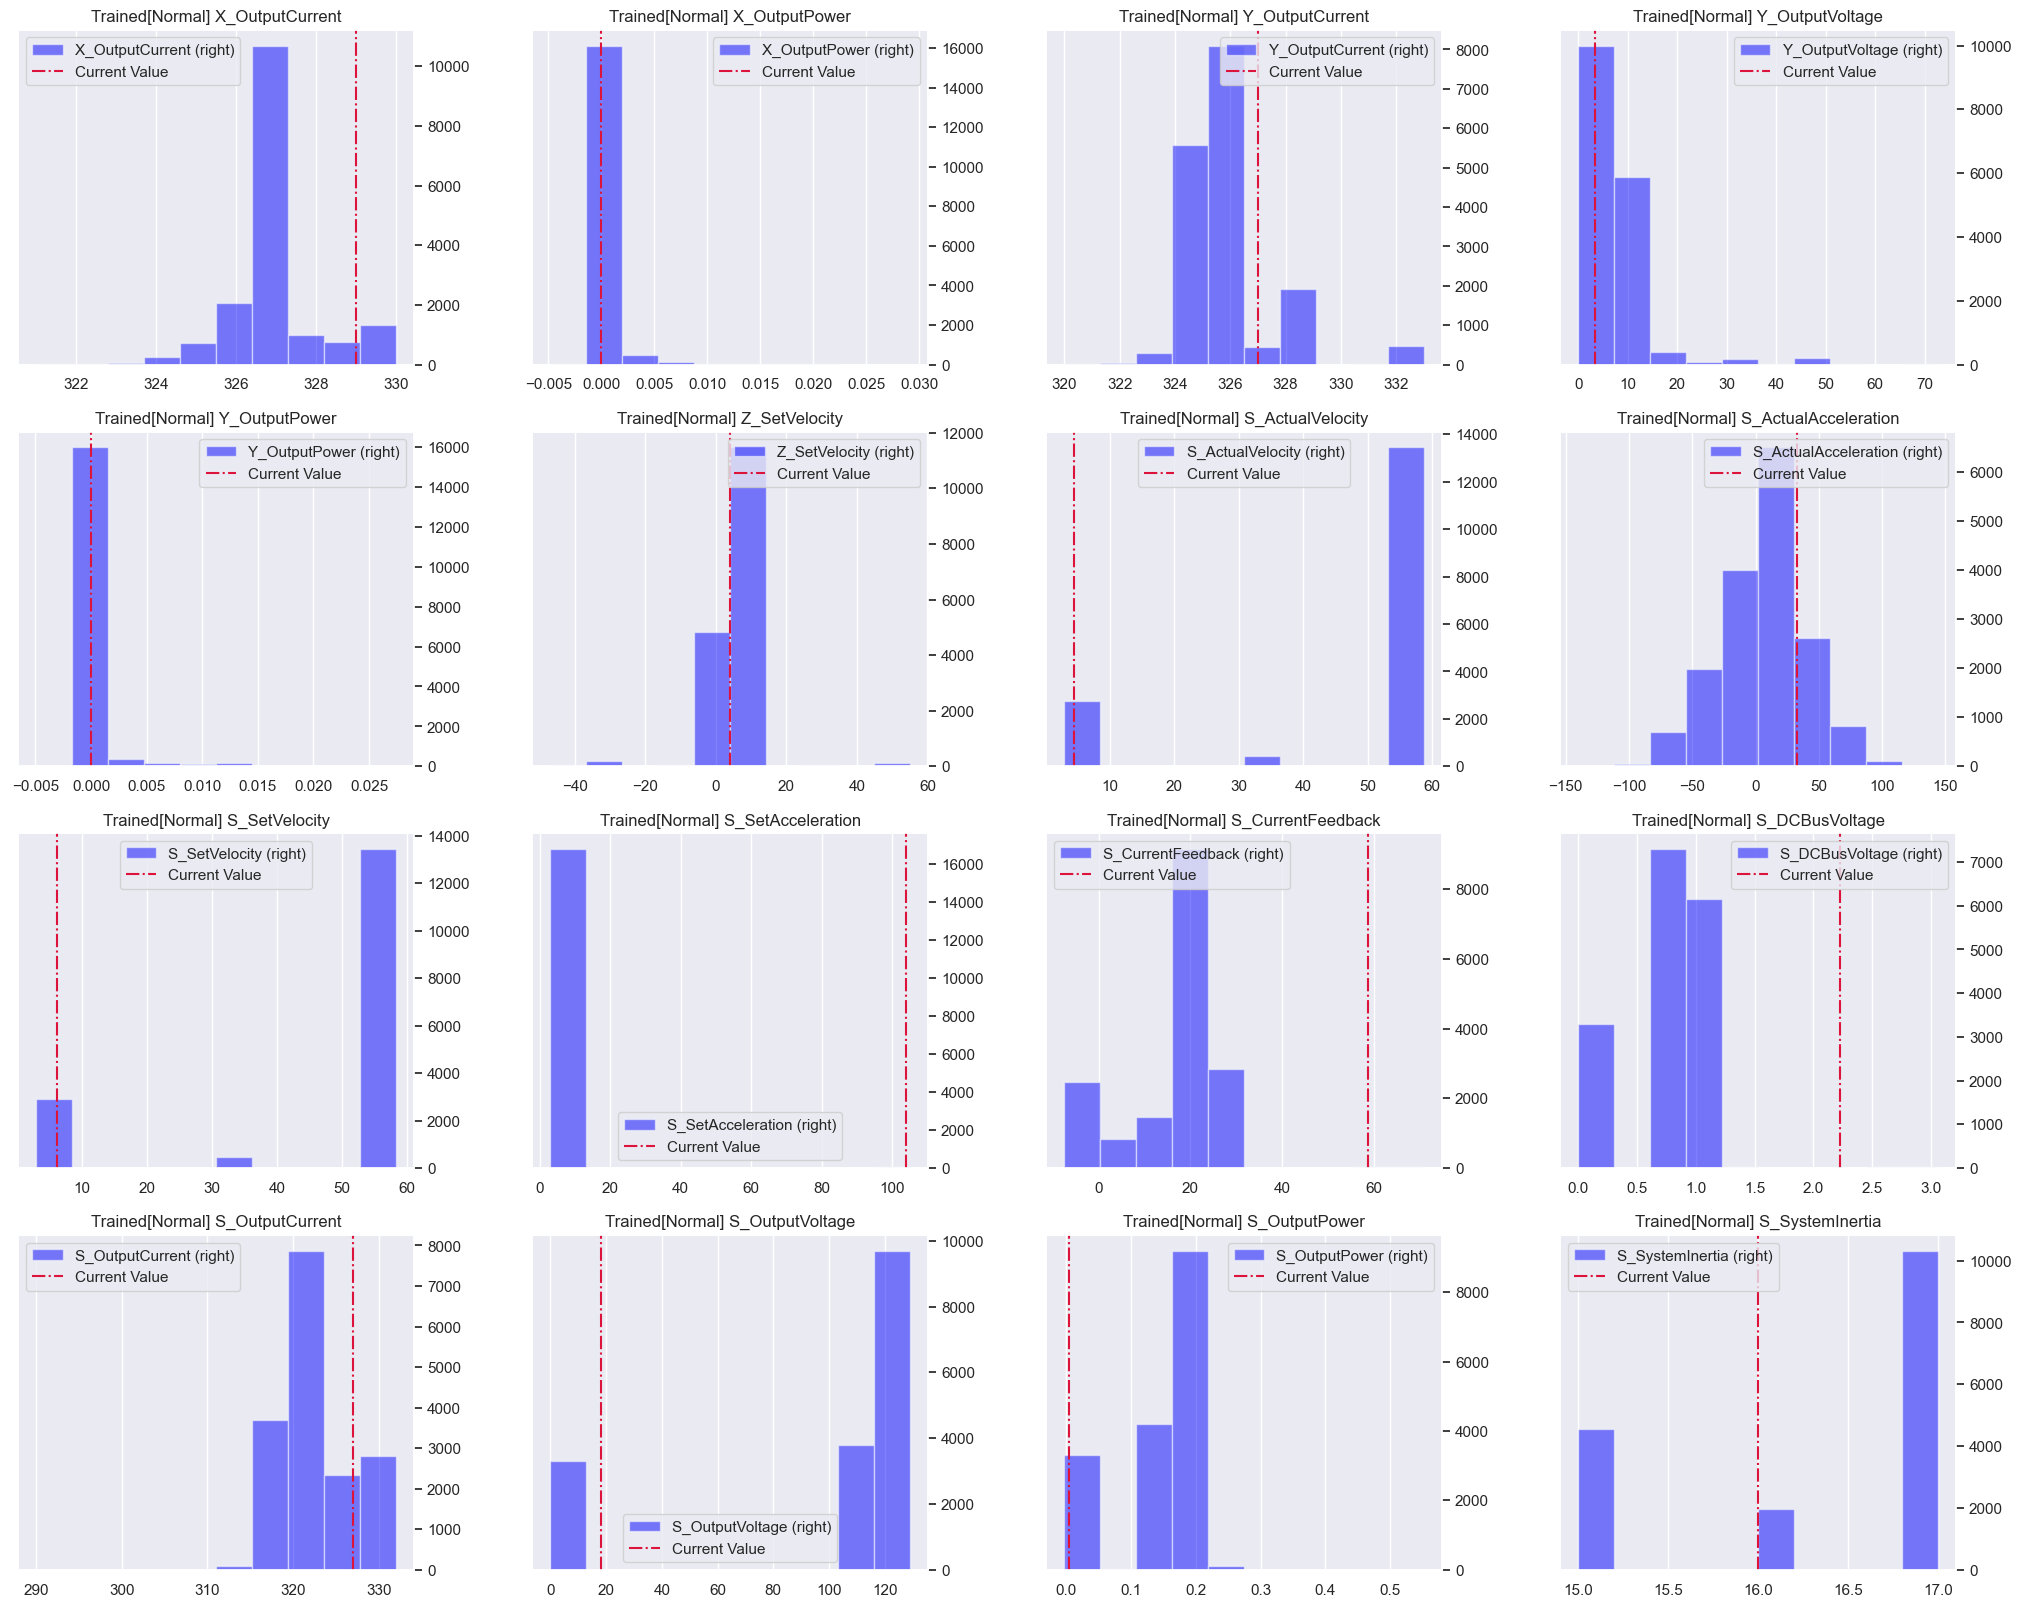

In [21]:
input_df = pred_fault[pred_fault['_id'] == fault_ids[_id]] # 불량 예측 데이터 ID 기준 출력 
print('ID --> ',input_df['_id'].iloc[0])

sns.set(font_scale=1.0)
fig, ax = plt.subplots(4,4, figsize=(25,20)) # 데이터 개수에 따라 플롯 형태 변경 가능 
fig.subplots_adjust(hspace = .2, wspace=.3, )
ax = ax.ravel()
for i in range(len(imp_cols)):
    ax[i] = Trained_Normal[imp_cols].iloc[:,i].plot(kind='hist', ax=ax[i],color='blue',alpha=0.5,secondary_y=True,bins=10)
    plt.axvline(input_df[imp_cols].iloc[:,i].iloc[0],linestyle='dashdot',color='crimson',label='Current Value')
    plt.legend()
    plt.title('Trained[Normal] ' +Trained_Normal[imp_cols].columns[i])

Id -->  ID_20231108_0


Columns: ['X_OutputCurrent', 'X_OutputPower', 'Y_OutputCurrent', 'Y_OutputVoltage', 'Y_OutputPower', 'Z_SetVelocity', 'S_ActualVelocity', 'S_ActualAcceleration', 'S_SetVelocity', 'S_SetAcceleration', 'S_CurrentFeedback', 'S_DCBusVoltage', 'S_OutputCurrent', 'S_OutputVoltage', 'S_OutputPower', 'S_SystemInertia']


Column Values: [329, 4.88e-06, 327, 3.28, -9.04e-07, 4.0, 4.501, 32.7, 6.2, 104.0, 58.6, 2.23, 327, 18.1, 0.00442, 16.0]


Median Normal Values: [327.0, 0.000289, 326.0, 5.87, 1.39e-05, 5.0, 58.2, 4.25, 58.3, 5.0, 19.4, 0.873, 322.0, 117.0, 0.167, 17.0]


Confidence Range =  | Input - Upper/Lower Boundary | ± 5
Diagnosis Result -->


X_OutputCurrent  =  329


하위 측정값 설정: 326.0
중앙 측정값 : 327.0
상위 10% 측정값 : 329.0


진단 결과
Value in Set Normal Quantile Range
X_OutputCurrent  --> 현재 값 유지




X_OutputPower  =  4.88e-06


하위 측정값 설정: -1.17e-05
중앙 측정값 : 0.000289
상위 10% 측정값 : 0.00101


진단 결과
Value in Set Normal Quantile Range
X_OutputPower  --> 현재 값 유지




Y_OutputC

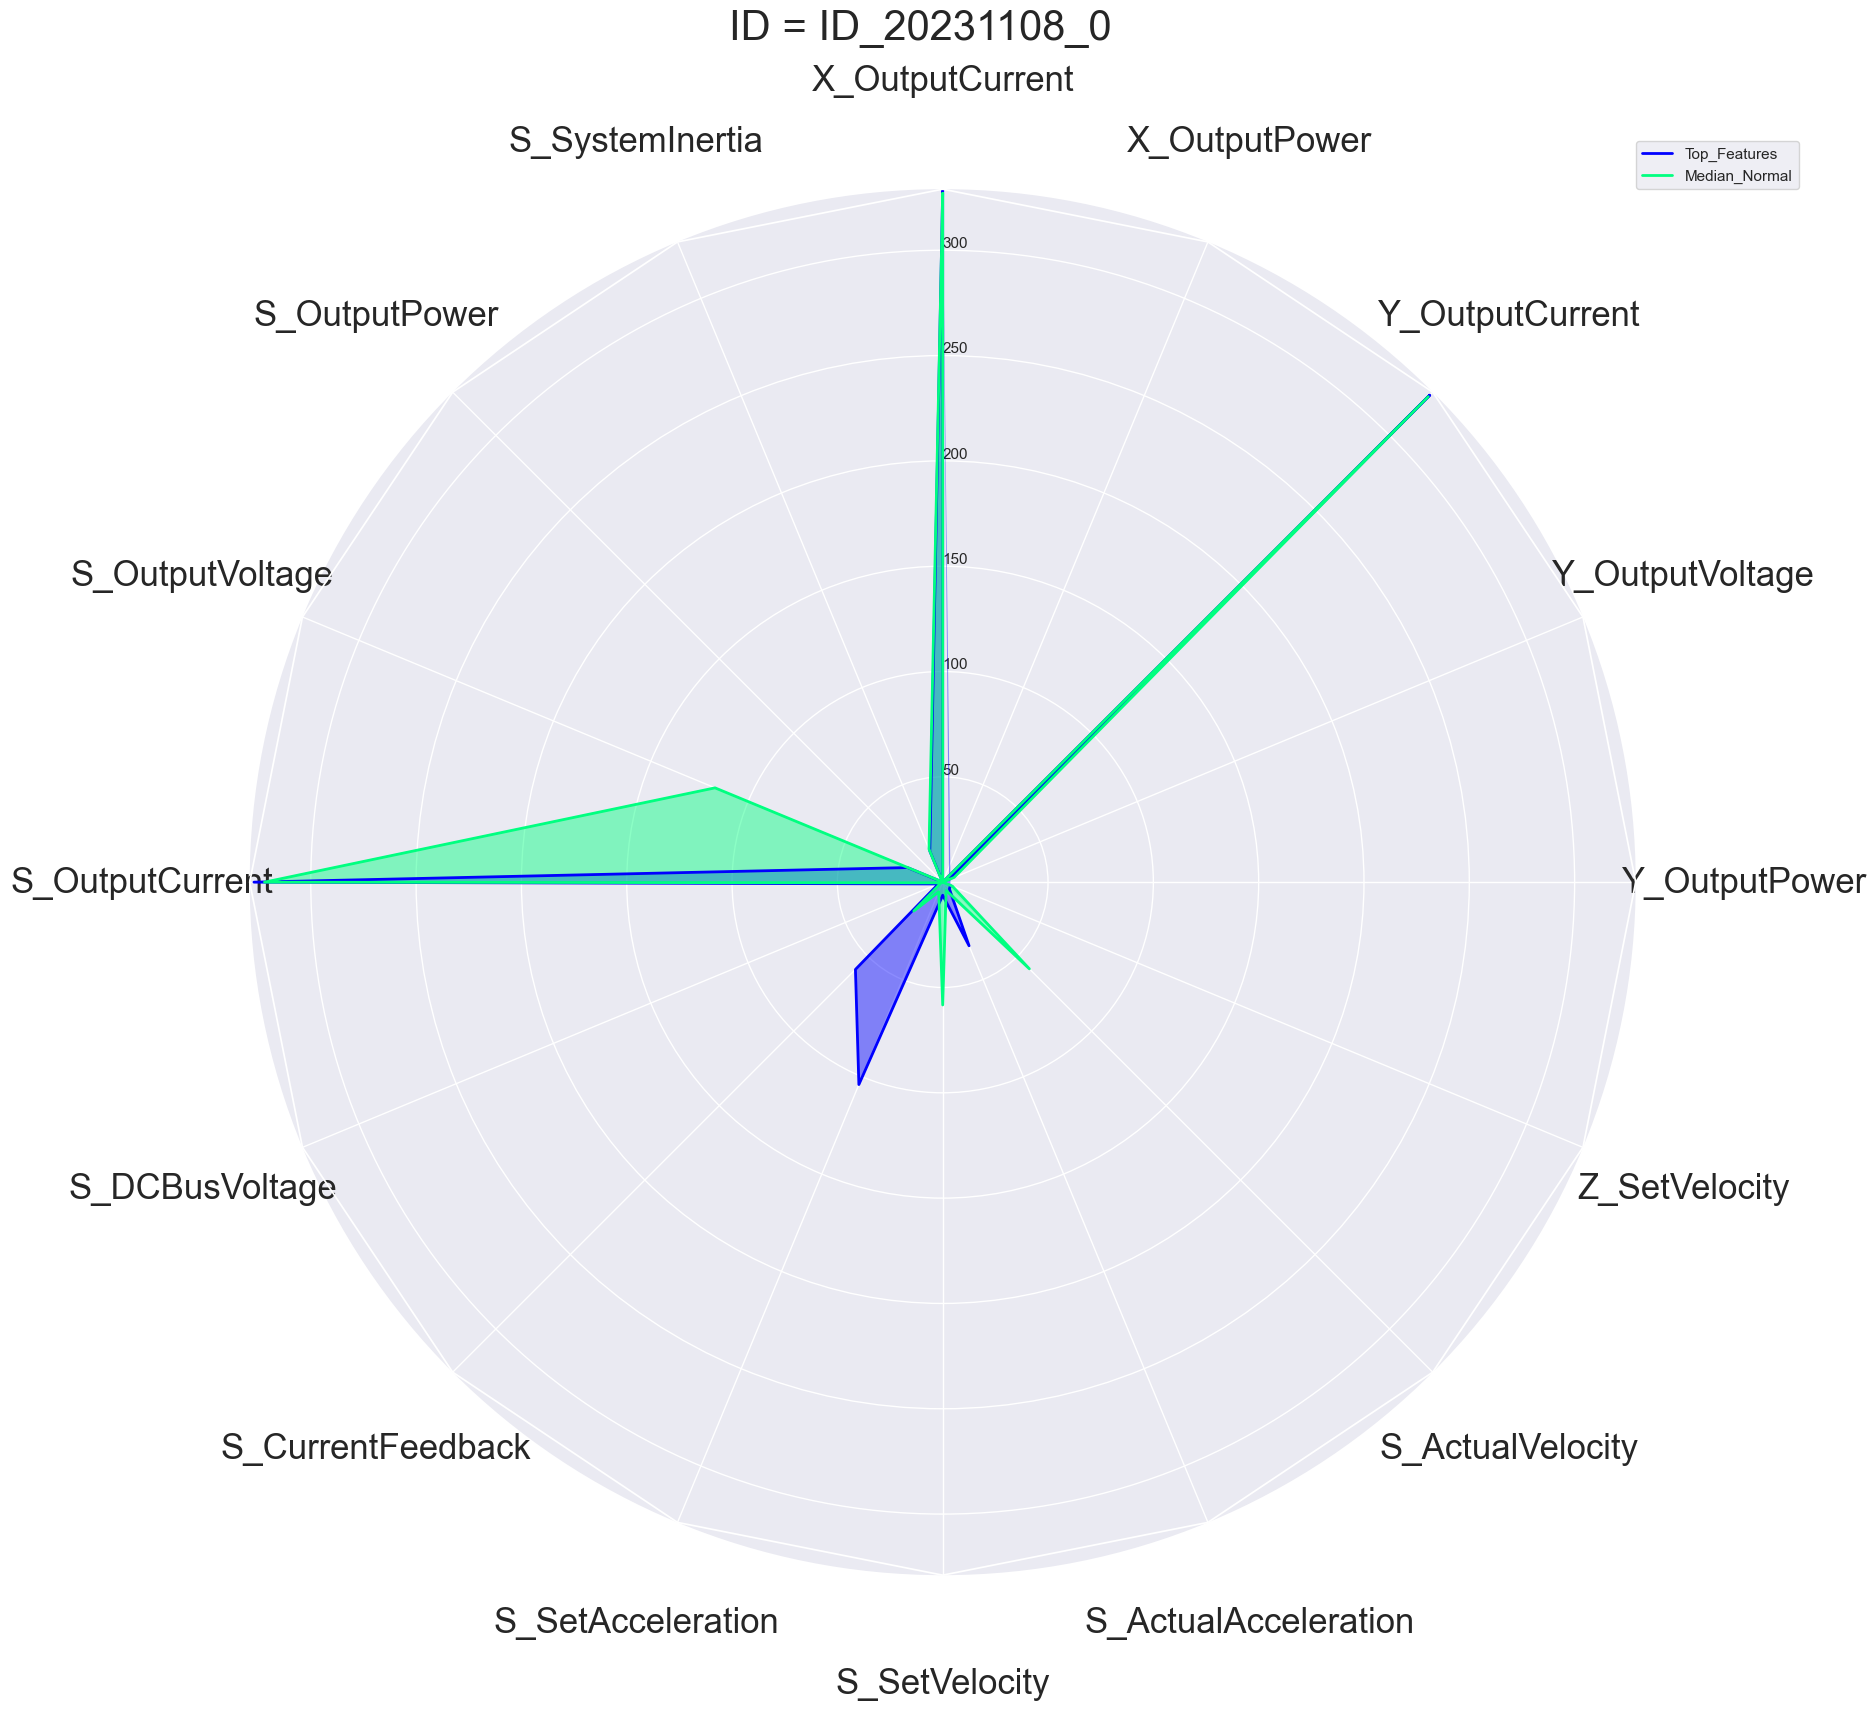

1/1 [==============================] - 0s 12ms/step
Optimization Result


Threshold =  0.1
Original MAE Loss =  0.13753004281153702
Adjusted MAE Loss =  0.08514718233218857


Predicted --> Normal


In [22]:
lower_quantile = 0.1
col_range = 5

input_adjusted = comprehensive_fault_diagnosis(_id,lower_quantile,col_range) 
optimization(_id)